In [18]:
import datetime

today = datetime.datetime.now().strftime("%Y%m%d")

### Prepare the data

In [19]:
import pandas as pd

reviews_df = pd.read_csv('../02.Dataset/reviews_300k.csv')

In [20]:
print(f"Dataset loaded:")
print(f"  - Total ratings: {len(reviews_df)}")
print(f"  - Unique users: {reviews_df['userId'].nunique()}")
print(f"  - Unique products: {reviews_df['productId'].nunique()}")
print(f"  - Rating range: {reviews_df['rating'].min()} - {reviews_df['rating'].max()}")
print(f"  - Rating distribution:")
print(reviews_df["rating"].value_counts().sort_index())

Dataset loaded:
  - Total ratings: 296836
  - Unique users: 181741
  - Unique products: 881
  - Rating range: 1 - 5
  - Rating distribution:
rating
1      2732
2      1820
3      4577
4     26513
5    261194
Name: count, dtype: int64


In [1]:
from TextProcessor import TextProcessor

pre = TextProcessor(
    teencode_path="../02.Dataset/vietnamese/teencode.csv",
    stopword_path="../02.Dataset/vietnamese/stopwords.txt",
    phrase_rules_path="../02.Dataset/vietnamese/phrase_rules.csv",
)

reviews_df["processed"] = reviews_df["comment"].apply(lambda x: pre.preprocess(x) if pd.notnull(x) and x.strip() != "" else "")

NameError: name 'reviews_df' is not defined

In [22]:
import joblib
import numpy as np

sentiment_analysis_model = joblib.load(
    "../05.Models/20250615_sentiment_analysis_model.pkl"
)

reviews_df["sentiment"] = np.nan
reviews_df["sentiment"] = reviews_df["processed"].apply(
    lambda x: (
        sentiment_analysis_model.predict([x])[0]
        if pd.notna(x) and x.strip() != ""
        else np.nan
    )
)

In [23]:
reviews_df.head()

,userId,productId,rating,comment,processed,sentiment
0,1394862,102440084,5,Tác phẩm có giá trị về tuyên truyền hơn là giá...,tác_phẩm giá_trị tuyên_truyền giá_trị lịch_sử ...,pos
1,22711549,102440084,5,NaN,,NaN
2,2169793,102440084,4,NaN,,NaN
3,14051602,102440084,5,Tác phẩm theo mình đánh giá là một trong những...,tác_phẩm đánh_giá tác_phẩm hay giúp ta hiểu hơ...,pos
4,28687742,102440084,5,NaN,,NaN


In [24]:
reviews_filtered_df = reviews_df.groupby("userId").filter(lambda x: len(x) > 3)
reviews_filtered_df.reset_index(drop=True, inplace=True)

# K1: Dữ liệu gốc, không thay đổi
k1_df = reviews_filtered_df[["userId", "productId", "rating"]].copy()


# K2: Loại bỏ đánh giá không hợp lệ
def is_valid_review(row):
    if row["sentiment"] == "pos" and row["rating"] <= 2:
        return False
    if row["sentiment"] == "neg" and row["rating"] >= 4:
        return False
    return True


k2_df = reviews_filtered_df[reviews_filtered_df.apply(is_valid_review, axis=1)][
    ["userId", "productId", "rating"]
].copy()


# K3: Điều chỉnh lại điểm số cho các đánh giá mâu thuẫn
def adjust_rating(row):
    original_rating = row["rating"]
    sentiment = row["sentiment"]

    # Ưu tiên 'comment', fallback sang 'processed'
    comment = row.get("comment")
    if pd.isna(comment) or not isinstance(comment, str):
        comment = row.get("processed")
    if pd.isna(comment) or not isinstance(comment, str):
        comment = ""

    comment = comment.strip()

    if len(comment) < 3:
        return float(original_rating)

    sentiment_reference = 4.5 if sentiment == "pos" else 1.5
    comment_length = len(comment)

    if comment_length < 10:
        comment_weight = 0.1
    elif comment_length < 30:
        comment_weight = 0.2
    elif comment_length < 100:
        comment_weight = 0.3
    else:
        comment_weight = 0.4

    is_inconsistent = False
    inconsistency_strength = 0.0

    if sentiment == "pos" and original_rating <= 2:
        is_inconsistent = True
        inconsistency_strength = 0.7
    elif sentiment == "pos" and original_rating == 3:
        is_inconsistent = True
        inconsistency_strength = 0.4
    elif sentiment == "neg" and original_rating >= 4:
        is_inconsistent = True
        inconsistency_strength = 0.7
    elif sentiment == "neg" and original_rating == 3:
        is_inconsistent = True
        inconsistency_strength = 0.4

    if is_inconsistent:
        adjustment_weight = comment_weight * inconsistency_strength
        adjusted = (
            1 - adjustment_weight
        ) * original_rating + adjustment_weight * sentiment_reference
    else:
        mild_adjustment = min(0.1, comment_weight * 0.2)
        adjusted = (
            1 - mild_adjustment
        ) * original_rating + mild_adjustment * sentiment_reference

    return max(1.0, min(5.0, round(adjusted, 1)))


reviews_filtered_df["adjusted_rating"] = reviews_filtered_df.apply(adjust_rating, axis=1)
k3_df = reviews_filtered_df.copy()
k3_df["rating"] = k3_df["adjusted_rating"]
k3_df = k3_df[["userId", "productId", "rating"]]

In [25]:
def summarize_data(df, label):
    print(f"\n📊 {label}")
    print(f"  - Tổng số lượt đánh giá: {len(df)}")
    print(f"  - Số người dùng: {df['userId'].nunique()}")
    print(f"  - Số sản phẩm: {df['productId'].nunique()}")
    print(f"  - Khoảng điểm: {df['rating'].min()} – {df['rating'].max()}")
    print("  - Phân phối điểm đánh giá:")
    print(df["rating"].value_counts().sort_index())


# Bước 6: In thống kê
summarize_data(k1_df, "K1 – Dữ liệu gốc")
summarize_data(k2_df, "K2 – Đã lọc đánh giá không hợp lệ")
summarize_data(k3_df, "K3 – Điều chỉnh điểm đánh giá")


📊 K1 – Dữ liệu gốc
  - Tổng số lượt đánh giá: 73271
  - Số người dùng: 12068
  - Số sản phẩm: 811
  - Khoảng điểm: 1 – 5
  - Phân phối điểm đánh giá:
rating
1      436
2      276
3      824
4     5658
5    66077
Name: count, dtype: int64

📊 K2 – Đã lọc đánh giá không hợp lệ
  - Tổng số lượt đánh giá: 69819
  - Số người dùng: 12038
  - Số sản phẩm: 808
  - Khoảng điểm: 1 – 5
  - Phân phối điểm đánh giá:
rating
1      389
2      243
3      824
4     4851
5    63512
Name: count, dtype: int64

📊 K3 – Điều chỉnh điểm đánh giá
  - Tổng số lượt đánh giá: 73271
  - Số người dùng: 12068
  - Số sản phẩm: 811
  - Khoảng điểm: 1.0 – 5.0
  - Phân phối điểm đánh giá:
rating
1.0      389
1.5        7
1.7       21
2.0      262
2.3        1
2.5       15
2.7       17
2.8      480
2.9       77
3.0       66
3.1       19
3.2      182
3.3      246
3.5      310
3.6      208
3.8       34
3.9        4
4.0     5528
4.3      896
4.5      522
4.8      325
4.9       85
5.0    63577
Name: count, dtype: int64


In [26]:
k1_df.to_csv("../02.Dataset/ratings_k1_original.csv", index=False)
k2_df.to_csv("../02.Dataset/ratings_k2_filtered.csv", index=False)
k3_df.to_csv("../02.Dataset/ratings_k3_adjusted.csv", index=False)

### Evaluate the MF model

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


class MFRecommender:
    def __init__(self, n_factors=20, n_epochs=50, lr=0.005, reg=0.01):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg
        self.P = None
        self.Q = None
        self.user_to_index = {}
        self.product_to_index = {}
        self.index_to_user = {}
        self.index_to_product = {}
        self.train_df = None
        self.test_df = None

    def _clip(self, value, min_val=-5.0, max_val=5.0):
        return max(min_val, min(max_val, value))

    def fit(self, train_df, test_df):
        all_users = pd.concat([train_df["userId"], test_df["userId"]]).unique()
        all_products = pd.concat([train_df["productId"], test_df["productId"]]).unique()

        self.user_to_index = {uid: idx for idx, uid in enumerate(all_users)}
        self.product_to_index = {pid: idx for idx, pid in enumerate(all_products)}
        self.index_to_user = {idx: uid for uid, idx in self.user_to_index.items()}
        self.index_to_product = {idx: pid for pid, idx in self.product_to_index.items()}

        # Lưu lại với index đã map
        self.train_df = train_df.copy()
        self.test_df = test_df.copy()
        self.train_df["user_idx"] = self.train_df["userId"].map(self.user_to_index)
        self.train_df["product_idx"] = self.train_df["productId"].map(
            self.product_to_index
        )
        self.test_df["user_idx"] = self.test_df["userId"].map(self.user_to_index)
        self.test_df["product_idx"] = self.test_df["productId"].map(
            self.product_to_index
        )

        n_users = len(self.user_to_index)
        n_items = len(self.product_to_index)
        self.P = np.random.normal(0, 0.01, (n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.01, (n_items, self.n_factors))

        train_rmse, test_rmse = [], []

        for epoch in range(self.n_epochs):
            for _, row in self.train_df.iterrows():
                u, i = int(row["user_idx"]), int(row["product_idx"])
                r_ui = row["rating"]

                pred = self._clip(np.dot(self.P[u], self.Q[i]))
                err = r_ui - pred

                for f in range(self.n_factors):
                    grad_p = self.lr * (err * self.Q[i][f] - self.reg * self.P[u][f])
                    grad_q = self.lr * (err * self.P[u][f] - self.reg * self.Q[i][f])
                    self.P[u][f] += self._clip(grad_p, -0.5, 0.5)
                    self.Q[i][f] += self._clip(grad_q, -0.5, 0.5)

            train_rmse.append(self.evaluate(self.train_df))
            test_rmse.append(self.evaluate(self.test_df))

            print(
                f"Epoch {epoch+1}/{self.n_epochs} - Train RMSE: {train_rmse[-1]:.4f} - Test RMSE: {test_rmse[-1]:.4f}"
            )

        # Learning curve
        plt.plot(range(1, self.n_epochs + 1), train_rmse, label="Train RMSE")
        plt.plot(range(1, self.n_epochs + 1), test_rmse, label="Test RMSE")
        plt.xlabel("Epoch")
        plt.ylabel("RMSE")
        plt.title("Learning Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, df=None):
      if df is None:
          if self.test_df is not None:
              df = self.test_df
          else:
              raise ValueError("Không có tập dữ liệu để đánh giá (test_df chưa được khởi tạo).")

      preds = [
          self._clip(
              np.dot(self.P[int(row["user_idx"])], self.Q[int(row["product_idx"])]))
          for _, row in df.iterrows()
      ]
      actual = df["rating"].values
      return np.sqrt(np.mean((np.array(preds) - actual) ** 2))

    def recommend_for_user(self, user_id, top_k=10, exclude_seen=True, ratings_df=None):
        if user_id not in self.user_to_index:
            return []

        user_idx = self.user_to_index[user_id]
        seen_items = (
            set(ratings_df[ratings_df["userId"] == user_id]["productId"].values)
            if exclude_seen
            else set()
        )
        scores = []

        for pid, idx in self.product_to_index.items():
            if pid in seen_items:
                continue
            pred_rating = self._clip(np.dot(self.P[user_idx], self.Q[idx]))
            scores.append((pid, pred_rating))

        scores.sort(key=lambda x: x[1], reverse=True)
        return [pid for pid, _ in scores[:top_k]]

    def save_model(self, file_path="mf_model.pkl"):
        with open(file_path, "wb") as f:
            pickle.dump(self.__dict__, f)

    def load_model(self, file_path="mf_model.pkl"):
        with open(file_path, "rb") as f:
            self.__dict__ = pickle.load(f)
            


🔍 Đang xử lý: K1 - Gốc
Epoch 1/20 - Train RMSE: 4.8885 - Test RMSE: 4.8896
Epoch 2/20 - Train RMSE: 4.8790 - Test RMSE: 4.8836
Epoch 3/20 - Train RMSE: 4.4584 - Test RMSE: 4.5756
Epoch 4/20 - Train RMSE: 2.9962 - Test RMSE: 3.2846
Epoch 5/20 - Train RMSE: 2.0065 - Test RMSE: 2.3326
Epoch 6/20 - Train RMSE: 1.4614 - Test RMSE: 1.7931
Epoch 7/20 - Train RMSE: 1.1412 - Test RMSE: 1.4756
Epoch 8/20 - Train RMSE: 0.9419 - Test RMSE: 1.2800
Epoch 9/20 - Train RMSE: 0.8093 - Test RMSE: 1.1530
Epoch 10/20 - Train RMSE: 0.7164 - Test RMSE: 1.0664
Epoch 11/20 - Train RMSE: 0.6487 - Test RMSE: 1.0047
Epoch 12/20 - Train RMSE: 0.5977 - Test RMSE: 0.9593
Epoch 13/20 - Train RMSE: 0.5583 - Test RMSE: 0.9249
Epoch 14/20 - Train RMSE: 0.5270 - Test RMSE: 0.8982
Epoch 15/20 - Train RMSE: 0.5016 - Test RMSE: 0.8770
Epoch 16/20 - Train RMSE: 0.4805 - Test RMSE: 0.8599
Epoch 17/20 - Train RMSE: 0.4627 - Test RMSE: 0.8459
Epoch 18/20 - Train RMSE: 0.4473 - Test RMSE: 0.8342
Epoch 19/20 - Train RMSE: 0.433

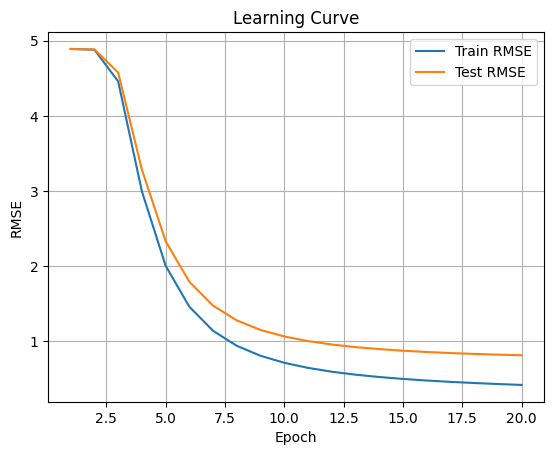

✅ K1 - Gốc - Final Test RMSE: 0.8161

🔍 Đang xử lý: K2 - Lọc đánh giá
Epoch 1/20 - Train RMSE: 4.8965 - Test RMSE: 4.8969
Epoch 2/20 - Train RMSE: 4.8892 - Test RMSE: 4.8925
Epoch 3/20 - Train RMSE: 4.5764 - Test RMSE: 4.6716
Epoch 4/20 - Train RMSE: 3.2023 - Test RMSE: 3.4815
Epoch 5/20 - Train RMSE: 2.1573 - Test RMSE: 2.4884
Epoch 6/20 - Train RMSE: 1.5681 - Test RMSE: 1.9142
Epoch 7/20 - Train RMSE: 1.2190 - Test RMSE: 1.5724
Epoch 8/20 - Train RMSE: 0.9997 - Test RMSE: 1.3586
Epoch 9/20 - Train RMSE: 0.8533 - Test RMSE: 1.2183
Epoch 10/20 - Train RMSE: 0.7501 - Test RMSE: 1.1218
Epoch 11/20 - Train RMSE: 0.6743 - Test RMSE: 1.0533
Epoch 12/20 - Train RMSE: 0.6169 - Test RMSE: 1.0033
Epoch 13/20 - Train RMSE: 0.5721 - Test RMSE: 0.9658
Epoch 14/20 - Train RMSE: 0.5363 - Test RMSE: 0.9372
Epoch 15/20 - Train RMSE: 0.5072 - Test RMSE: 0.9148
Epoch 16/20 - Train RMSE: 0.4831 - Test RMSE: 0.8970
Epoch 17/20 - Train RMSE: 0.4629 - Test RMSE: 0.8827
Epoch 18/20 - Train RMSE: 0.4456 - Tes

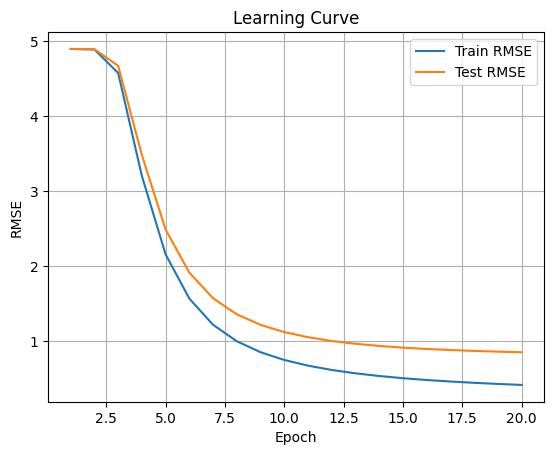

✅ K2 - Lọc đánh giá - Final Test RMSE: 0.8530

🔍 Đang xử lý: K3 - Điều chỉnh điểm
Epoch 1/20 - Train RMSE: 4.8628 - Test RMSE: 4.8640
Epoch 2/20 - Train RMSE: 4.8569 - Test RMSE: 4.8604
Epoch 3/20 - Train RMSE: 4.5621 - Test RMSE: 4.6500
Epoch 4/20 - Train RMSE: 3.1437 - Test RMSE: 3.4197
Epoch 5/20 - Train RMSE: 2.0943 - Test RMSE: 2.4175
Epoch 6/20 - Train RMSE: 1.5172 - Test RMSE: 1.8472
Epoch 7/20 - Train RMSE: 1.1795 - Test RMSE: 1.5120
Epoch 8/20 - Train RMSE: 0.9707 - Test RMSE: 1.3065
Epoch 9/20 - Train RMSE: 0.8332 - Test RMSE: 1.1740
Epoch 10/20 - Train RMSE: 0.7376 - Test RMSE: 1.0839
Epoch 11/20 - Train RMSE: 0.6681 - Test RMSE: 1.0202
Epoch 12/20 - Train RMSE: 0.6161 - Test RMSE: 0.9736
Epoch 13/20 - Train RMSE: 0.5759 - Test RMSE: 0.9384
Epoch 14/20 - Train RMSE: 0.5442 - Test RMSE: 0.9110
Epoch 15/20 - Train RMSE: 0.5184 - Test RMSE: 0.8893
Epoch 16/20 - Train RMSE: 0.4970 - Test RMSE: 0.8719
Epoch 17/20 - Train RMSE: 0.4789 - Test RMSE: 0.8577
Epoch 18/20 - Train RMSE: 

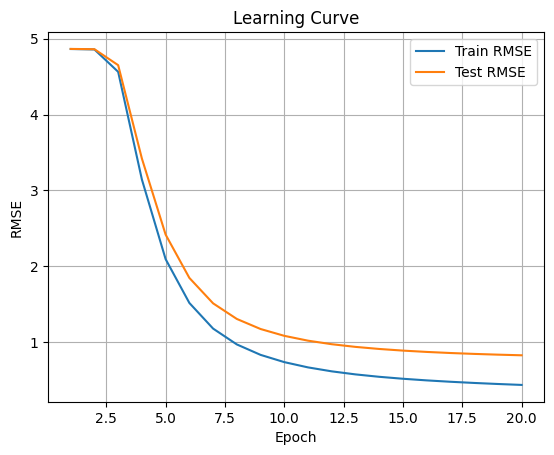

✅ K3 - Điều chỉnh điểm - Final Test RMSE: 0.8276

📊 So sánh RMSE giữa các kịch bản:
            Kịch bản  Test RMSE
            K1 - Gốc     0.8161
   K2 - Lọc đánh giá     0.8530
K3 - Điều chỉnh điểm     0.8276


In [ ]:
from sklearn.model_selection import train_test_split


files = {
    "K1 - Gốc": "../02.Dataset/ratings_k1_original.csv",
    "K2 - Lọc đánh giá": "../02.Dataset/ratings_k2_filtered.csv",
    "K3 - Điều chỉnh điểm": "../02.Dataset/ratings_k3_adjusted.csv",
}

results = []

# Huấn luyện và đánh giá mô hình SVD trên từng kịch bản
for name, filepath in files.items():
    print(f"\n🔍 Đang xử lý: {name}")
    df = pd.read_csv(filepath)

    # Chia train/test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Huấn luyện mô hình
    mf_model = MFRecommender(n_factors=20, n_epochs=20, lr=0.01, reg=0.02)
    mf_model.fit(train_df, test_df)

    # Đánh giá mô hình
    final_test_rmse = mf_model.evaluate()
    print(f"✅ {name} - Final Test RMSE: {final_test_rmse:.4f}")

    results.append({"Kịch bản": name, "Test RMSE": round(final_test_rmse, 4)})

# Tổng hợp kết quả
results_df = pd.DataFrame(results)
print("\n📊 So sánh RMSE giữa các kịch bản:")
print(results_df.to_string(index=False))


In [30]:
if results:
    import pandas as pd

    summary_df = pd.DataFrame(results)
    print("\n📊 So sánh kết quả giữa các kịch bản:")
    print(summary_df.to_string(index=False))


📊 So sánh kết quả giữa các kịch bản:
            Kịch bản  Test RMSE
            K1 - Gốc     0.6448
   K2 - Lọc đánh giá     0.6804
K3 - Điều chỉnh điểm     0.6594


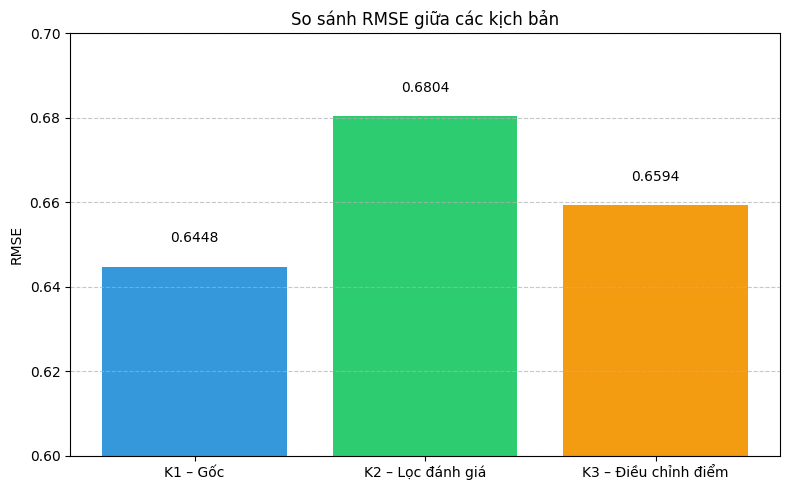

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử đây là kết quả bạn đã tính được
results = [
    {"Kịch bản": "K1 – Gốc", "Test RMSE": 0.6448},
    {"Kịch bản": "K2 – Lọc đánh giá", "Test RMSE": 0.6804},
    {"Kịch bản": "K3 – Điều chỉnh điểm", "Test RMSE": 0.6594},
]

df = pd.DataFrame(results)

# Tạo biểu đồ cột
plt.figure(figsize=(8, 5))
bars = plt.bar(df["Kịch bản"], df["Test RMSE"], color=["#3498db", "#2ecc71", "#f39c12"])

# Thêm nhãn giá trị trên đầu cột
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.005,
        f"{height:.4f}",
        ha="center",
        va="bottom",
    )

plt.title("So sánh RMSE giữa các kịch bản")
plt.ylabel("RMSE")
plt.ylim(0.6, 0.7)  # Tùy chỉnh nếu cần
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Lưu hình ảnh để chèn vào Overleaf
plt.savefig("rmse_comparison.png", dpi=300)
plt.show()